In [1]:
import tensorflow as tf
import numpy as np 
from sklearn.datasets import fetch_california_housing
from IPython.display import clear_output, Image, display, HTML

In [2]:
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

In [4]:
### Get data and set boundary
percent = 0.9
housing = fetch_california_housing()

total_len = len(housing.data)
train_len = int(total_len * percent)
test_len = total_len - train_len
feature_len = len(housing.feature_names)

In [5]:
### Set training and test data
def feature_normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

X_train, X_test = np.split(np.float32(feature_normalize(housing.data)), [train_len])
y_train, y_test = np.split(np.float32(housing.target), [train_len])

y_train = y_train.reshape([train_len, 1])
y_test = y_test.reshape([test_len, 1])

In [6]:
#### Parameters
learning_rate = 0.3
training_epochs = 1000

In [7]:
### Create TF structure
X = tf.placeholder(tf.float32, [None, feature_len])
y = tf.placeholder(tf.float32, [None, 1])

In [8]:
### Gradient method
Weights = tf.Variable(tf.random_uniform([feature_len, 1], 1.0, -1.0))
biases = tf.Variable(tf.ones([1]))

y_predict = tf.matmul(X,Weights) + biases

loss_history = np.empty(shape=[1], dtype=float)

loss = tf.reduce_mean(tf.square(y_predict - y_train))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [9]:
###### Start TF session ######
config = tf.ConfigProto(device_count = {'GPU': 1})
config.gpu_options.allow_growth = True

sess = tf.Session()
sess.run(init)
    
for epoch in range(training_epochs):
#     if epoch % 20 == 0:
#         print(epoch, sess.run(Weights), sess.run(biases))
    sess.run(train, feed_dict={X: X_train, y: y_train})
    loss_history = np.append(loss_history, 
                             sess.run(loss, feed_dict={X: X_train, y: y_train}))
print(sess.run(Weights))   
print('done')

[[ 0.84053874]
 [ 0.12394544]
 [-0.28168997]
 [ 0.32278204]
 [-0.00191841]
 [-0.05835282]
 [-0.92267388]
 [-0.89473665]]
done


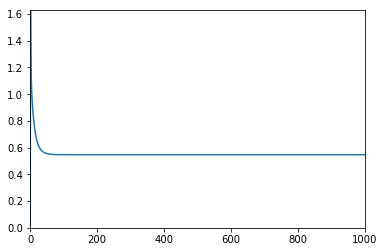

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_history)), loss_history)
plt.axis([0, training_epochs, 0, np.max(loss_history)])
plt.show()

MSE: 0.3442


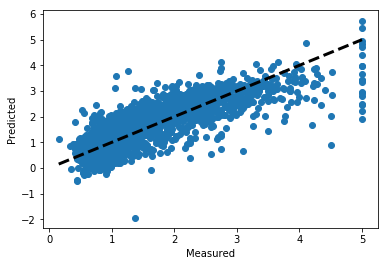

In [11]:
y_ = sess.run(y_predict, feed_dict={X: X_test})
mse = tf.reduce_mean(tf.abs(y_ - y_test)/ y_test)
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(y_test, y_)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
# why plot x and y are same?
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()